<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 

<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:

from google.colab import drive

drive.mount('/content/gdrive')
proot_path = "gdrive/My Drive/Colab Notebooks/Positive_tensors"
nroot_path = "gdrive/My Drive/Colab Notebooks/Negative_tensors" 

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug  3 02:26:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
# !unzip -o Positive_tensors.zip -d /gdrive/My\ Drive/Colab\ Notebooks/Positive_tensors/

In [4]:
# ! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
# !unzip -o Negative_tensors.zip -d /gdrive/My\ Drive/Colab\ Notebooks/Negative_tensors/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will install torchvision:


In [6]:
!pip install torchvision
!pip install Pillow

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [7]:
# These are the libraries will be used for this lab.
import torchvision.models as models
import PIL 
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [8]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


In [9]:
# os.chdir("/content/drive/MyDrive/Colab Notebooks")
# !ls

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [10]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content/drive/MyDrive/Colab Notebooks"
        positive="Positive_tensors"
        negative="Negative_tensors"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        # print(number_of_samples)
        # print(len(positive_files))
        # print(len(negative_files))
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [11]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [12]:
# Step 1: Load the pre-trained model resnet18
# This code was produced by Jesus Garcia

model = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [13]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for parameter in model.parameters():
  parameter.requires_grad = False

#Accelerate hardware:
# hardware = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(hardware)
# model.to(hardware)

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [14]:
# opt = torch.optim.Adam([element in element in model.parameters() if element.requires_grad], lr=0.001)
model.fc = nn.Linear(512, 2)


Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [16]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [17]:
load_train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
load_valid = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)


<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [18]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [19]:
# Accelerate hardware:
hardware = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(hardware)
model.to(hardware)

n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in load_train:

        x, y = x.to(hardware), y.to(hardware)
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        yhat = model(x)
        # calculate loss 
        loss = criterion(yhat, y)
        loss_list.append(loss.data.item())
        loss.backward()
        # calculate gradients of parameters 
        optimizer.step()
        # update parameters 
        mean_data = np.mean(loss_list)
        loss_list.append(mean_data)
        # print("Epoch: " + str(epoch+1))
        # print("Avg Loss: " + str(mean_data))

    correct=0
    for x_test, y_test in load_valid:

        x_test, y_test = x_test.to(hardware), y_test.to(hardware)
        # set model to eval 
        model.eval()
        #make a prediction 
        mod = model(x_test)
        #find max 
        p, y_ht = torch.max(mod.data, dim=1) 
        #Calculate misclassified  samples in mini-batch 
        correct += (y_ht == y_test).sum().item()
        accuracy=correct/N_test
        # print("Accuracy: " + str(round(accuracy,4)))
        accuracy_list.append(accuracy)


cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [20]:
accuracy

0.995

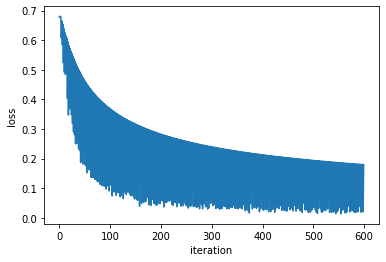

In [21]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


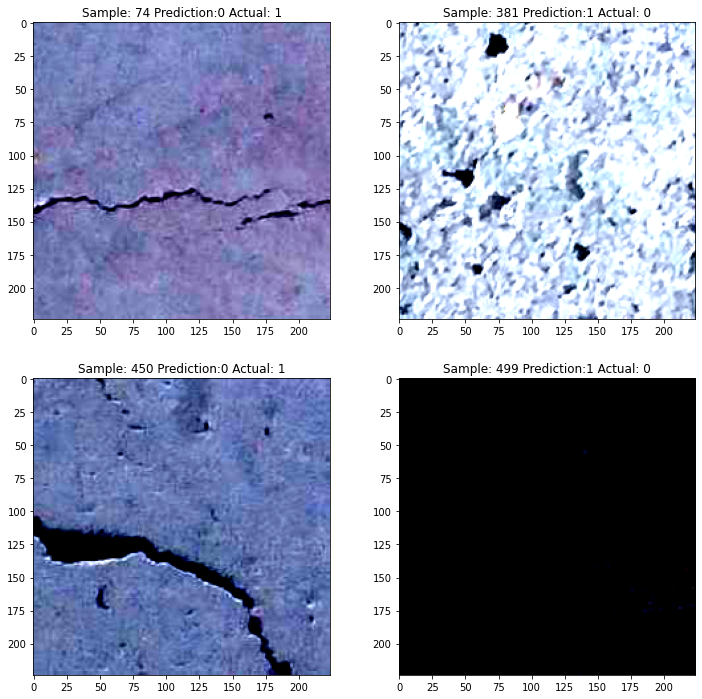

In [29]:
yt_lab = []
yh_lab = []

for x_t, y_t in load_valid:
    x_t, y_t = x_t.to(hardware), y_t.to(hardware)
    model.eval()
    instance = model(x_t)
    _, yhat = torch.max(instance.data, dim=1)
    yt_lab.extend(y_t.tolist())
    yh_lab.extend(yhat.tolist())

misclassified_ind = [index for index in range(len(yh_lab)) if yt_lab[index] != yh_lab[index]]

plt.figure(22, figsize=(12,12))
for img in range(4):
    i = misclassified_ind[img]
    x = np.transpose(validation_dataset[i][0], (1,2,0))
    plt.subplot(221+img)
    plt.title("Sample: " + str(misclassified_ind[img]) + " Prediction:" + str(yh_lab[i]) + " Actual: " + str(yt_lab[i]))
    plt.imshow(x)

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-21        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright © 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.
